In [534]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
import os
import sys
from importlib import reload
sys.path.append('')
import deck_load
import inspect
import warnings
warnings.filterwarnings("ignore")
import plot_type
import intake

In [537]:
#  institution, model, ensemble,variable
ipsl = deck_load.Deck('IPSL','IPSL-CM6A-LR','r1i1p1f1','ts')

In [538]:
ipsl

DECK data for IPSL IPSL-CM6A-LR 
**** ENS: r1i1p1f1 
**** VAR: ts

 --------------- 

Summary of: self.data
Coordinates:
  * time      (time) object 1850-01-16 12:00:00 ... 3849-12-16 12:00:00
  * lat       (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 86.2 87.46 88.73 90.0
  * lon       (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * scenario  (scenario) object '1pctCO2' 'abrupt-4xCO2' ... 'piControl'
Var: ts


In [539]:
# The anomalies based upon the 1850 to 1900 climatology,
ipsl_anom = ipsl.anomalies()
ipsl_anom

Weighted Space mean of DECK data for IPSL IPSL-CM6A-LR 
**** ENS: r1i1p1f1 
**** VAR: ts
Time frame: 1850 - 3849


In [541]:
# The space mean of the anomaies (smean)
ipsl_anom_smean = ipsl_anom.space_mean()
ipsl_anom_smean

<xarray.DataArray 'ts' (scenario: 4, time: 2000)>
dask.array<truediv, shape=(4, 2000), dtype=float32, chunksize=(1, 8), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 1850-12-31 00:00:00 ... 3849-12-31 00:00:00
  * scenario  (scenario) object '1pctCO2' 'abrupt-4xCO2' ... 'piControl'

In [542]:
# PUtting the space mean anomalies into memory, so each time I use the data it doesn't have to be
# recalcualted.
ipsl_anom_smean = ipsl_anom_smean.compute()

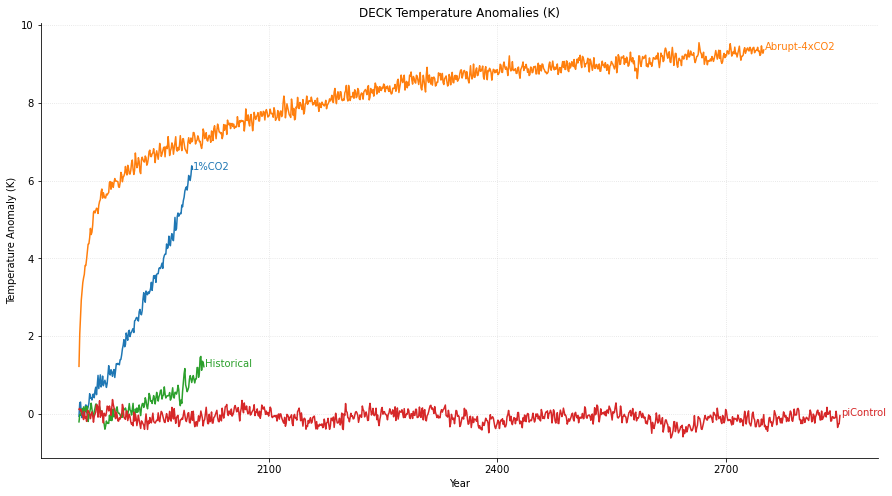

In [617]:
plot_type = reload(plot_type)

data = ipsl_anom_smean

fig, ax = plt.subplots(figsize = (15,8))

time = data.time.values
for scenario in data.scenario.values:
    plot_type.plot_line_with_annotation(data.sel(scenario = scenario), time,ax,
                              label = scenario, deltax = 1)

ax.set_title('DECK Temperature Anomalies (K)');

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Year')
ax.set_ylabel('Temperature Anomaly (K)')
ax.grid(alpha = 0.4, linestyle = ':')

In [618]:
ipsl_anom_smean = ipsl_anom_smean.isel(time = slice(None, 1000))

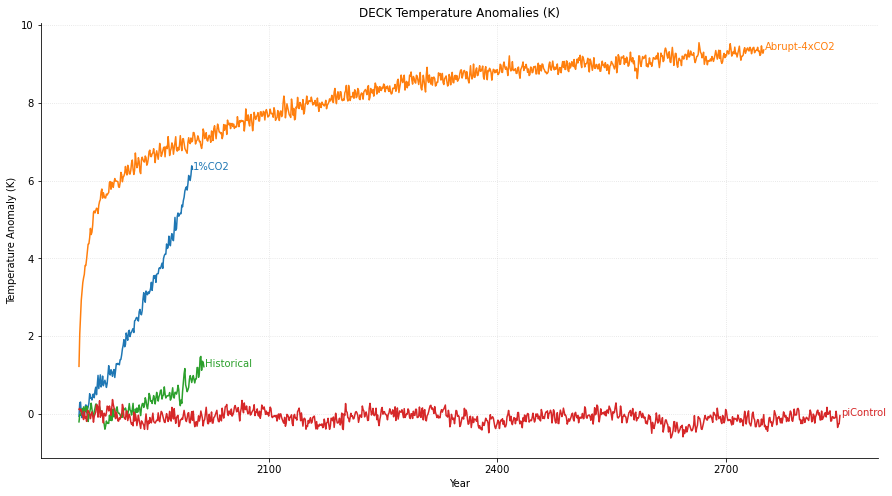

In [619]:
plot_type = reload(plot_type)

data = ipsl_anom_smean

fig, ax = plt.subplots(figsize = (15,8))

time = data.time.values
for scenario in data.scenario.values:
    plot_type.plot_line_with_annotation(data.sel(scenario = scenario), time,ax,
                              label = scenario, deltax = 1)

ax.set_title('DECK Temperature Anomalies (K)');

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Year')
ax.set_ylabel('Temperature Anomaly (K)')
ax.grid(alpha = 0.4, linestyle = ':')

# Signal to Noise

In [684]:
ROLL_PERIOD = 27
MIN_PERIOD = 27

## Signal

In [685]:
def grid_trend(x, use = [0][0]):
    # Use = [0][0] will just return the gradient
    # USe  = [0,1] will return the gradient and y-intercept.
    
    if all(~np.isfinite(x)):
        return np.nan
    
    # If every point is just a nan values. We don't want to do the polyfit calculation. Just return nan
    t = np.arange(len(x))

    # Getting the gradient of a linear interpolation
    idx = np.isfinite(x) #checking where the nans.
    x = x[idx]
    t = t[idx]
    
    if len(x) < 3:
        return np.nan
    
    poly = np.polyfit(t,x,1)
    
    return poly[use]

In [686]:
grid_trend(np.array([0,1,2,3,4,5]), use = [0][0])

0.9999999999999998

In [687]:
ipsl_1pct = \
                ipsl_anom_smean.sel(scenario = '1pctCO2').where(
                np.isfinite(ipsl_anom_smean.sel(scenario = '1pctCO2')), 
                                                drop = True)

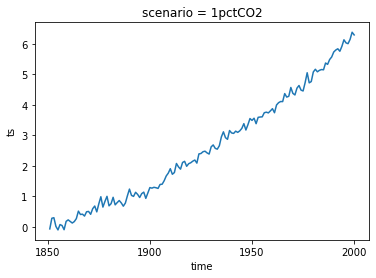

In [688]:
ipsl_1pct.plot()

In [689]:
grid_trend(ipsl_1pct.values)

0.04175485178065432

In [690]:
def trend_helper(arr, axis):
    print(arr.shape, axis[0])
    # func1ds, axis, arr 
    return np.apply_along_axis(grid_trend, axis[0], arr)

In [691]:
ROLL_PERIOD

27

In [692]:
ipsl_anom_smean.values.shape

(4, 1000)

In [693]:
ipsl_smean_signal = ipsl_anom_smean.rolling(time = ROLL_PERIOD,min_periods = MIN_PERIODS, center = True).reduce(trend_helper)
ipsl_smean_signal 

(4, 1000, 27) 2


<xarray.DataArray 'ts' (scenario: 4, time: 1000)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time      (time) object 1850-12-31 00:00:00 ... 2849-12-31 00:00:00
  * scenario  (scenario) object '1pctCO2' 'abrupt-4xCO2' ... 'piControl'

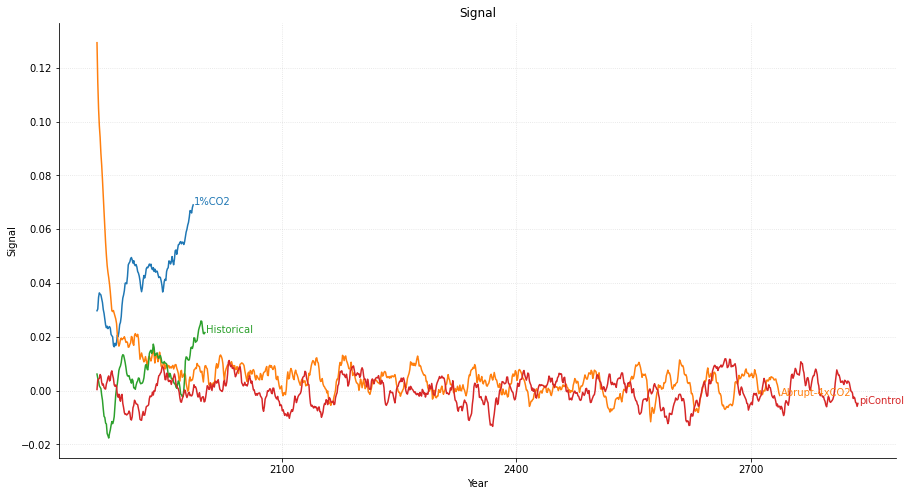

In [694]:
plot_type = reload(plot_type)

data = ipsl_smean_signal

fig, ax = plt.subplots(figsize = (15,8))

time = data.time.values
for scenario in data.scenario.values:
    plot_type.plot_line_with_annotation(data.sel(scenario = scenario), time,ax,
                              label = scenario, deltax = 1)

ax.set_title('Signal');

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Year')
ax.set_ylabel('Signal')
ax.grid(alpha = 0.4, linestyle = ':')

## Noise - Linear Detrend Standard Deviation

In [695]:
ipsl_anom_smean.scenario.values

array(['1pctCO2', 'abrupt-4xCO2', 'historical', 'piControl'], dtype=object)

1.11 0.53


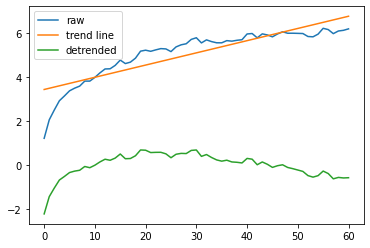

In [696]:
y = ipsl_anom_smean.sel(scenario = 'abrupt-4xCO2').isel(time = slice(0,61))
x = np.arange(len(y))

# Getting the gradient of a linear interpolation
idy = np.isfinite(y) #checking where the nans.
y = y[idy]
x = x[idy]



m,c = np.polyfit(x,y,1)

trend_line = m * x + c

y_detrend = y - trend_line

plt.plot(y, label = 'raw')
plt.plot(trend_line, label = 'trend line')
plt.plot(y_detrend, label = 'detrended')

print(np.round(np.std(y.values),2), np.round(np.std(y_detrend.values),2))

plt.legend()

1.83 0.28


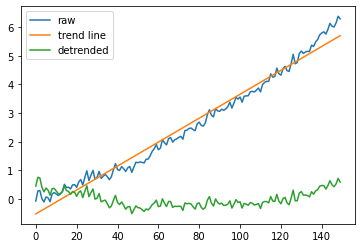

In [697]:
y = ipsl_1pct
x = np.arange(len(y))

# Getting the gradient of a linear interpolation
idy = np.isfinite(y) #checking where the nans.
y = y[idy]
x = x[idy]

m,c = np.polyfit(x,y,1)

trend_line = m * x + c

y_detrend = y - trend_line

plt.plot(y, label = 'raw')
plt.plot(trend_line, label = 'trend line')
plt.plot(y_detrend, label = 'detrended')

print(np.round(np.std(y.values),2), np.round(np.std(y_detrend.values),2))

plt.legend()

In [698]:
def grid_noise(y):
    x = np.arange(len(y))

    # Getting the gradient of a linear interpolation
    idy = np.isfinite(y) #checking where the nans.
    y = y[idy]
    x = x[idy]
    
    if len(y) < 10:
        return np.nan
    
    m,c = np.polyfit(x,y,1)

    trend_line = m * x + c

    y_detrend = y - trend_line

    std_detrend = np.std(y_detrend)
    
    return std_detrend

def std_detrend_helper(arr, axis):
    print(arr.shape, axis[0])
    # func1ds, axis, arr 
    return np.apply_along_axis(grid_noise, axis[0], arr)

In [700]:
ipsl_smean_noise = ipsl_anom_smean.rolling(time = ROLL_PERIOD, min_periods = MIN_PERIODS, center = True)\
        .reduce(std_detrend_helper) #** 2
ipsl_smean_noise

(4, 1000, 27) 2


<xarray.DataArray 'ts' (scenario: 4, time: 1000)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time      (time) object 1850-12-31 00:00:00 ... 2849-12-31 00:00:00
  * scenario  (scenario) object '1pctCO2' 'abrupt-4xCO2' ... 'piControl'

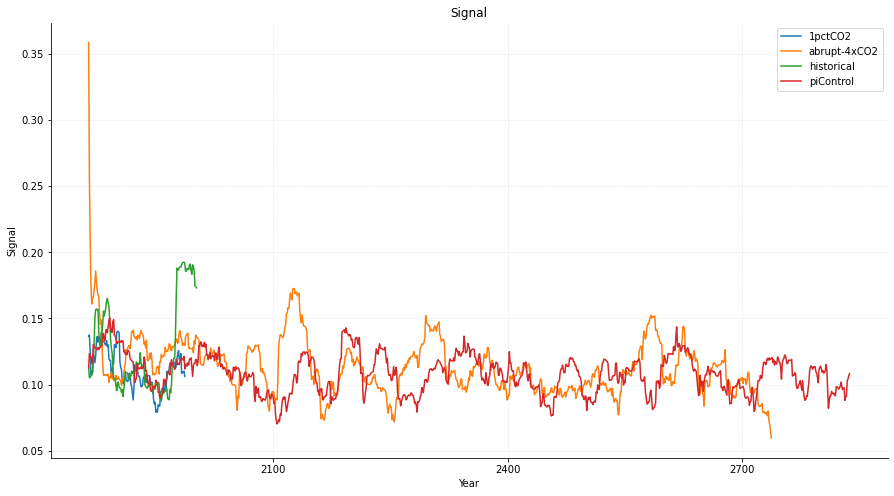

In [701]:
data = ipsl_smean_noise

fig, ax = plt.subplots(figsize = (15,8))

time = data.time.values
for scenario in data.scenario.values:
    ax.plot(time, data.sel(scenario = scenario), label = scenario)

ax.set_title('Signal');

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Year')
ax.set_ylabel('Signal')
ax.grid(alpha = 0.4, linestyle = ':')
ax.legend()

In [702]:
ipsl_smean_sn = ipsl_smean_signal/ipsl_smean_noise
ipsl_smean_sn['time'] = ipsl_smean_sn.time.values -  pd.to_timedelta(f'{(MIN_PERIODS - 1)/2}Y')
ipsl_smean_sn.coords

Coordinates:
  * time      (time) object 1837-12-30 20:20:24 ... 2836-12-30 20:20:24
  * scenario  (scenario) object '1pctCO2' 'abrupt-4xCO2' ... 'piControl'

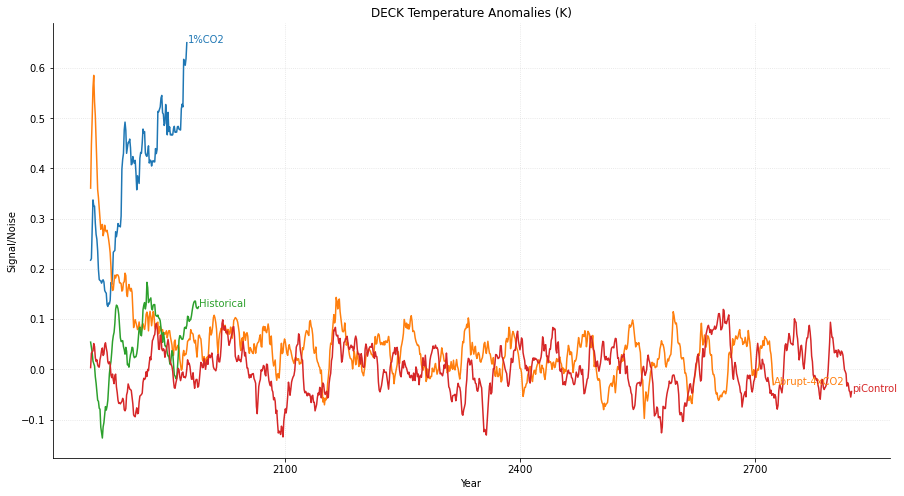

In [703]:
plot_type = reload(plot_type)

data = ipsl_smean_sn

fig, ax = plt.subplots(figsize = (15,8))

time = data.time.values
for scenario in data.scenario.values:
    plot_type.plot_line_with_annotation(data.sel(scenario = scenario), time,ax,
                              label = scenario, deltax = 1)

ax.set_title('DECK Temperature Anomalies (K)');

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Year')
ax.set_ylabel('Signal/Noise')
ax.grid(alpha = 0.4, linestyle = ':')

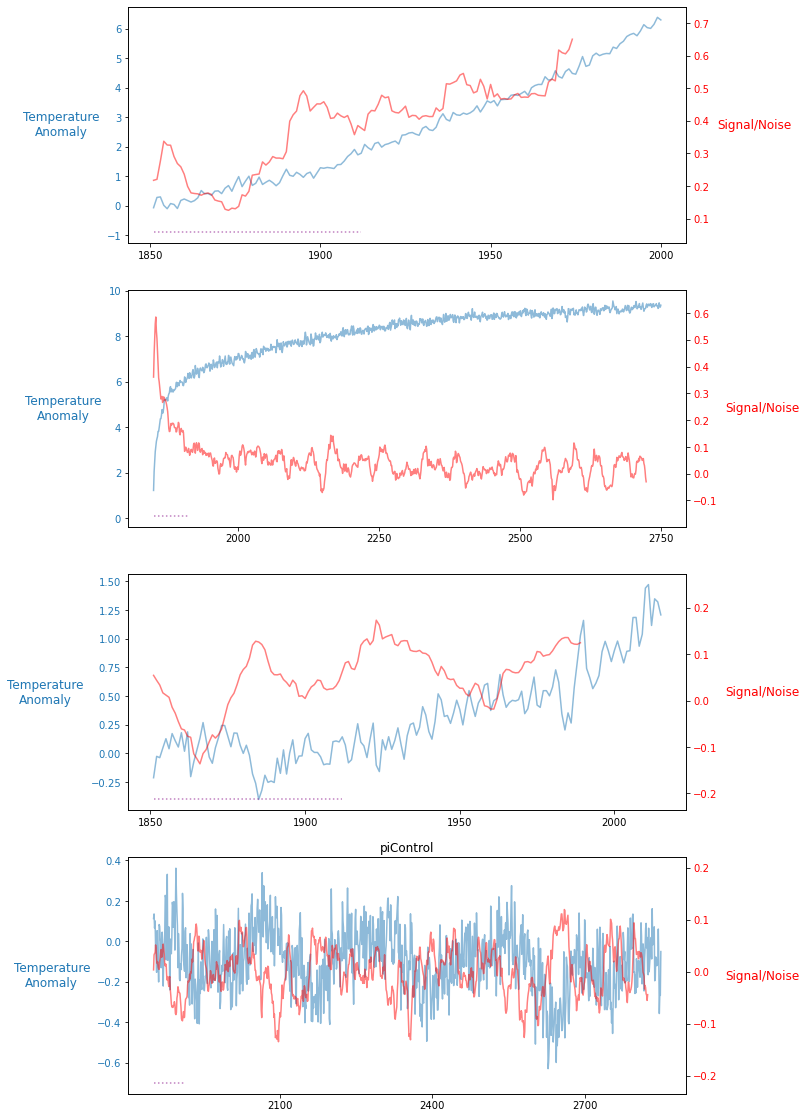

In [704]:
plot_type = reload(plot_type)
plot_type.temp_anom_and_signal_plot(ipsl_anom_smean, ipsl_smean_sn);

# Fixed Noise

In the above example noise was defined for the same rolling period. Here we are defining noise as a fixed value from the piControl.

In [716]:
ROLL_PERIOD

27

In [717]:
ipsl_smean_signal = ipsl_anom_smean.rolling(time = ROLL_PERIOD,min_periods =  MIN_PERIODS, center = True)\
                    .reduce(trend_helper)
ipsl_smean_signal 

(4, 1000, 27) 2


<xarray.DataArray 'ts' (scenario: 4, time: 1000)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time      (time) object 1850-12-31 00:00:00 ... 2849-12-31 00:00:00
  * scenario  (scenario) object '1pctCO2' 'abrupt-4xCO2' ... 'piControl'

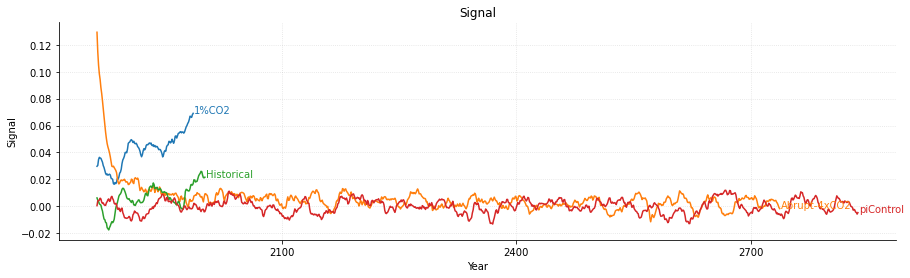

In [718]:
plot_type = reload(plot_type)

data = ipsl_smean_signal

fig, ax = plt.subplots(figsize = (15,4))

time = data.time.values
for scenario in data.scenario.values:
    plot_type.plot_line_with_annotation(data.sel(scenario = scenario), time,ax,
                              label = scenario, deltax = 1)

ax.set_title('Signal');

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Year')
ax.set_ylabel('Signal')
ax.grid(alpha = 0.4, linestyle = ':')

Noise

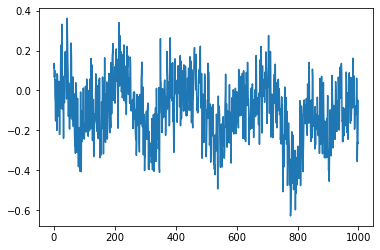

In [719]:
plt.plot(ipsl_anom_smean.sel(scenario = 'piControl'))

In [720]:
fixed_noise = np.std(ipsl_anom_smean.sel(scenario = 'piControl'))
fixed_noise.values

array(0.15308373)

In [721]:
ipsl_smean_sn_nfixed = ipsl_smean_signal/fixed_noise.values
ipsl_smean_sn_nfixed['time'] = ipsl_smean_sn_nfixed.time.values -  pd.to_timedelta(f'{(ROLL_PERIOD - 1)/2}Y')
ipsl_smean_sn_nfixed.coords

Coordinates:
  * time      (time) object 1837-12-30 20:20:24 ... 2836-12-30 20:20:24
  * scenario  (scenario) object '1pctCO2' 'abrupt-4xCO2' ... 'piControl'

In [722]:
ipsl_smean_signal.values[0][30:40]

array([0.02321244, 0.02087633, 0.02038801, 0.02000314, 0.01681328,
       0.01628368, 0.01759263, 0.01674641, 0.01790551, 0.02060075])

In [723]:
ipsl_smean_sn_nfixed.values[0][30:40]

array([0.15163233, 0.13637199, 0.1331821 , 0.13066799, 0.10983064,
       0.10637105, 0.11492163, 0.10939381, 0.11696549, 0.13457181])

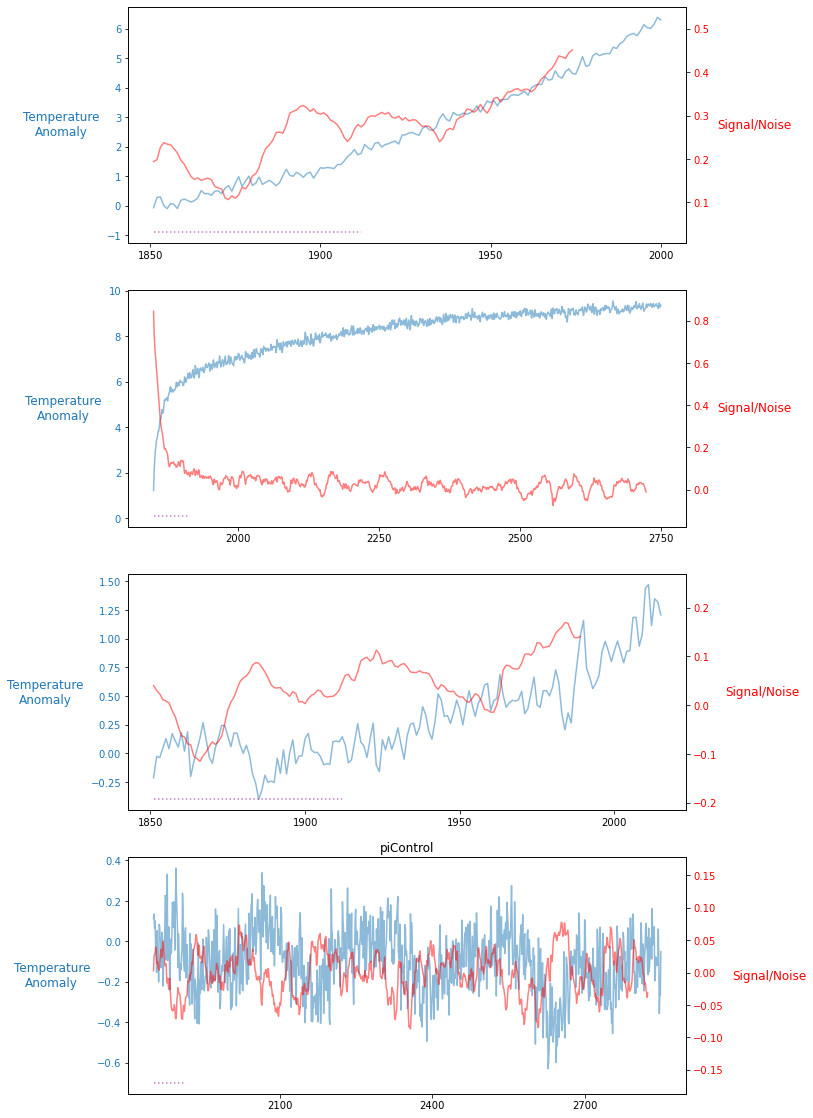

In [724]:
plot_type = reload(plot_type)
plot_type.temp_anom_and_signal_plot(ipsl_anom_smean, ipsl_smean_sn_nfixed);

# N-th Order Polynomial Fit

In [760]:
ipsl_abrupt = ipsl_anom_smean.sel(scenario = 'abrupt-4xCO2')
ipsl_abrupt = ipsl_abrupt.where(np.isfinite(ipsl_abrupt), drop = True)
y = ipsl_abrupt.values
y[:5]

array([1.2165939, 2.0547814, 2.502672 , 2.9215398, 3.1400602],
      dtype=float32)

In [726]:
idy = np.isfinite(y)
y = y[idy]
x = np.arange(len(y))

In [727]:
np.polyfit(x,y, deg = 1, full = False)

array([4.01622069e-03, 6.32503701e+00])

In [728]:
p1,residuals1, rank, singular_values, rcond = np.polyfit(x,y, deg = 1, full = True)

In [729]:
p_list = []
res_list = []

for deg in np.arange(1,15):
    p,res, rank, singular_values, rcond = np.polyfit(x,y, deg = deg, full = True)
    
    p_list.append(p)
    res_list.append(res)

In [762]:
p_list[:3]

[array([4.01622069e-03, 6.32503701e+00]),
 array([-7.17454396e-06,  1.04661357e-02,  5.35969973e+00]),
 array([ 1.50173199e-08, -2.74253998e-05,  1.77442963e-02,  4.81596020e+00])]

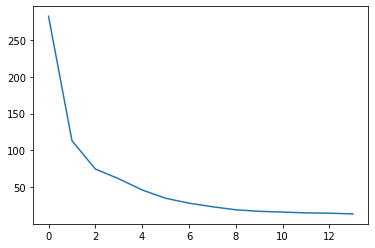

In [731]:
plt.plot(res_list)

In [732]:
def create_polynomial(p,x):
    
    x = x.astype(float)
    # This is the highest power in our polynomial
    power = len(p)

    # Creatin an empty array that everything can be added to.
    x_zeros = np.zeros_like(x)
    
    # Each value in the array will be multiplied by mult and then put to the poewr of (power)
    # First will be 0, so x ** 0 will be 1, so this will just be adding the translation.
    # Second will be 1, so the will be the a * x ^ 1
    # Third will be 2, so b * x ^ 2
    # and so on.
    for power, mult in enumerate(p[::-1]):
#         print(power, mult)
        x_zeros += mult * x ** power
        
    return x_zeros

In [733]:
p1_line = create_polynomial(p_list[0], x)
p1_line

array([6.32503701, 6.32905323, 6.33306946, 6.33708568, 6.3411019 ,
       6.34511812, 6.34913434, 6.35315056, 6.35716678, 6.361183  ,
       6.36519922, 6.36921544, 6.37323166, 6.37724788, 6.3812641 ,
       6.38528032, 6.38929654, 6.39331277, 6.39732899, 6.40134521,
       6.40536143, 6.40937765, 6.41339387, 6.41741009, 6.42142631,
       6.42544253, 6.42945875, 6.43347497, 6.43749119, 6.44150741,
       6.44552363, 6.44953986, 6.45355608, 6.4575723 , 6.46158852,
       6.46560474, 6.46962096, 6.47363718, 6.4776534 , 6.48166962,
       6.48568584, 6.48970206, 6.49371828, 6.4977345 , 6.50175072,
       6.50576694, 6.50978317, 6.51379939, 6.51781561, 6.52183183,
       6.52584805, 6.52986427, 6.53388049, 6.53789671, 6.54191293,
       6.54592915, 6.54994537, 6.55396159, 6.55797781, 6.56199403,
       6.56601026, 6.57002648, 6.5740427 , 6.57805892, 6.58207514,
       6.58609136, 6.59010758, 6.5941238 , 6.59814002, 6.60215624,
       6.60617246, 6.61018868, 6.6142049 , 6.61822112, 6.62223

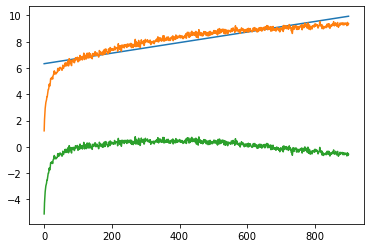

In [734]:
plt.plot(p1_line)
plt.plot(y)
plt.plot(y - p1_line)

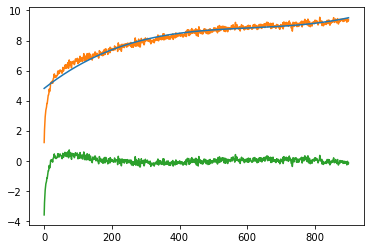

In [735]:
p2_line = create_polynomial(p_list[2], x)
plt.plot(p2_line)
plt.plot(y, zorder = -1)
plt.plot(y - p2_line)

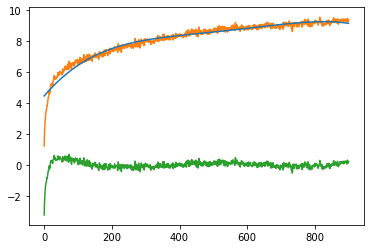

In [736]:
p3_line = create_polynomial(p_list[3], x)
plt.plot(p3_line)
plt.plot(y, zorder = -1)
plt.plot(y - p3_line)

In [737]:
len(p_list)

14

This plot goes through and plots:
* trend line
* raw data
* detrend data for all the different ploynomials in the p_data list

 In the example below this is for polynomials up to order 13

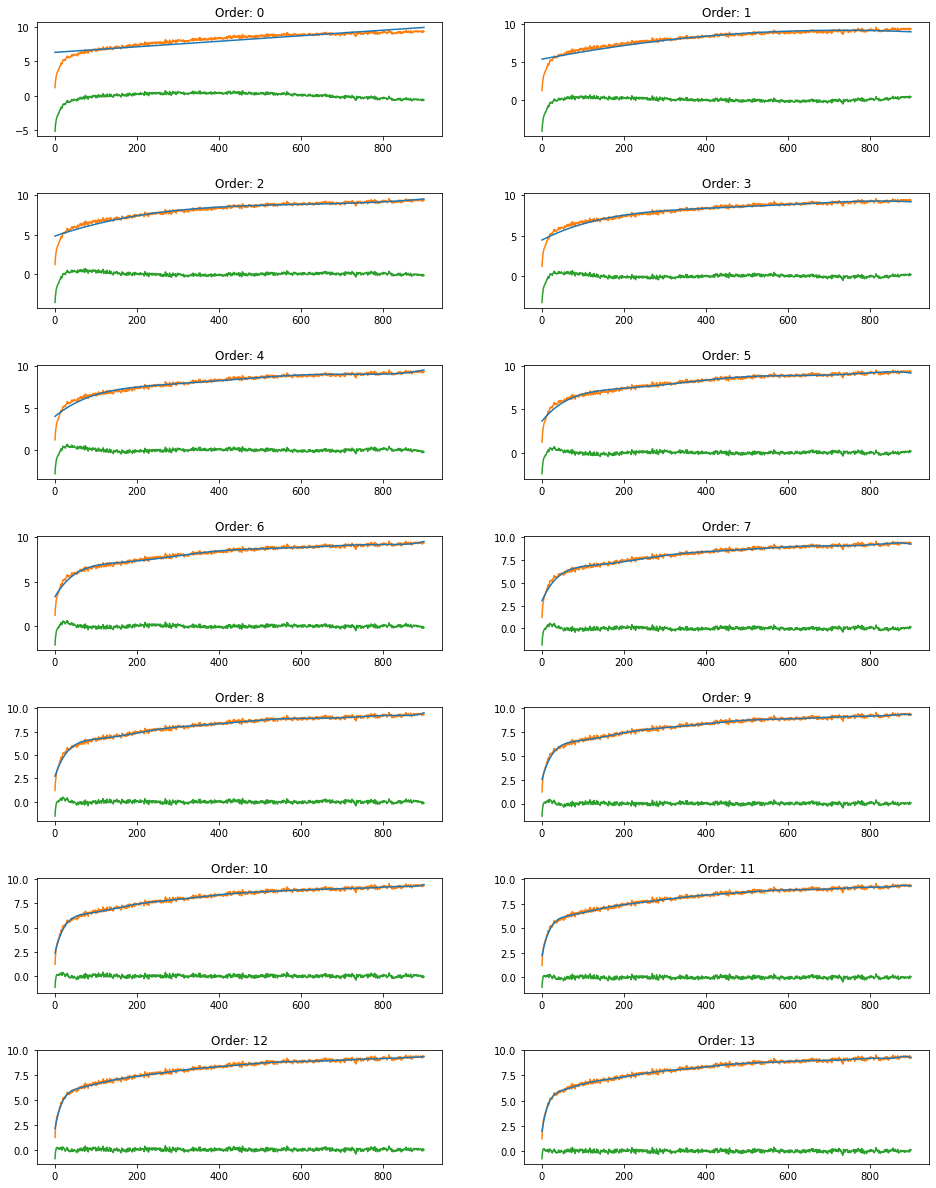

In [738]:

ncols = 2
nrows = int(np.ceil(len(p_list)/ncols))

fig = plt.figure(figsize = (8 * ncols, 3 * nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace = 0.5)

for p_num in np.arange(len(p_list)):
    
    ax = fig.add_subplot(gs[p_num])

    p_line = create_polynomial(p_list[p_num], x)
    
    ax.plot(p_line)
    ax.plot(y, zorder = -1)
    ax.plot(y - p_line)
    
    ax.set_title(f'Order: {str(p_num)}')

Detrended with highest order plynomial

Lets try with the 8th order poynomial.

In [759]:
ipsl_abrupt[:15]

<xarray.DataArray 'ts' (time: 15)>
array([1.2165939, 2.0547814, 2.502672 , 2.9215398, 3.1400602, 3.3714812,
       3.4917774, 3.5858033, 3.8124888, 3.813122 , 3.9828627, 4.187079 ,
       4.3639593, 4.372125 , 4.526365 ], dtype=float32)
Coordinates:
  * time      (time) object 1850-12-31 00:00:00 ... 1864-12-31 00:00:00
    scenario  <U12 'abrupt-4xCO2'

In [740]:
P_ORDER = 12

In [741]:
p_line = create_polynomial(p_list[P_ORDER], x)
ipsl_abrupt_detrend = ipsl_abrupt - p_line

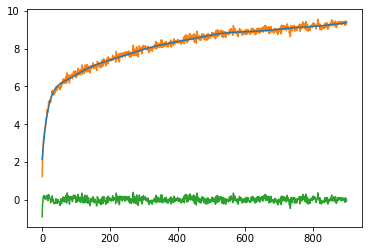

In [742]:
plt.plot(p_line)
plt.plot(ipsl_abrupt.values, zorder  = -1)
plt.plot(ipsl_abrupt_detrend)

In [765]:
ipsl_aburpt_noise_detrend =\
            ipsl_abrupt_detrend.rolling(time = ROLL_PERIOD, center = True).reduce(np.std)
ipsl_aburpt_noise_detrend[15:25]

<xarray.DataArray 'ts' (time: 10)>
array([0.10252713, 0.09940766, 0.10108972, 0.1046444 , 0.10173815,
       0.10501463, 0.11485543, 0.12379194, 0.12891427, 0.13655388])
Coordinates:
  * time      (time) object 1865-12-31 00:00:00 ... 1874-12-31 00:00:00
    scenario  <U12 'abrupt-4xCO2'

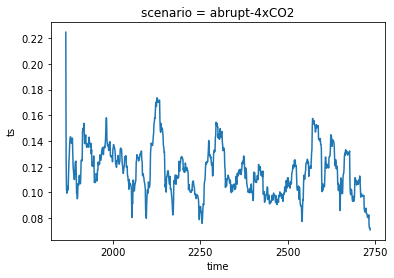

In [750]:
ipsl_aburpt_noise_detrend.plot()

In [751]:
ipsl_abrupt_signal = ipsl_smean_signal.sel(scenario = 'abrupt-4xCO2')
ipsl_abrupt_signal = ipsl_abrupt_signal.where(
                ipsl_abrupt_signal.time.isin(ipsl_aburpt_noise_detrend.time.values) , 
                drop = True)

In [766]:
ipsl_abrupt_signal[15:25]

<xarray.DataArray 'ts' (time: 10)>
array([0.10487951, 0.09841631, 0.09417049, 0.088187  , 0.08380872,
       0.07841884, 0.07211449, 0.06653794, 0.0606922 , 0.05498338])
Coordinates:
  * time      (time) object 1865-12-31 00:00:00 ... 1874-12-31 00:00:00
    scenario  <U12 'abrupt-4xCO2'

In [753]:
ipsl_abrupt_sn = ipsl_abrupt_signal/ipsl_aburpt_noise_detrend
ipsl_abrupt_sn['time'] = ipsl_abrupt_sn.time.values -  pd.to_timedelta(f'{(ROLL_PERIOD - 1)/2}Y')
ipsl_abrupt_sn.coords

Coordinates:
  * time      (time) object 1837-12-30 20:20:24 ... 2736-12-30 20:20:24
    scenario  <U12 'abrupt-4xCO2'

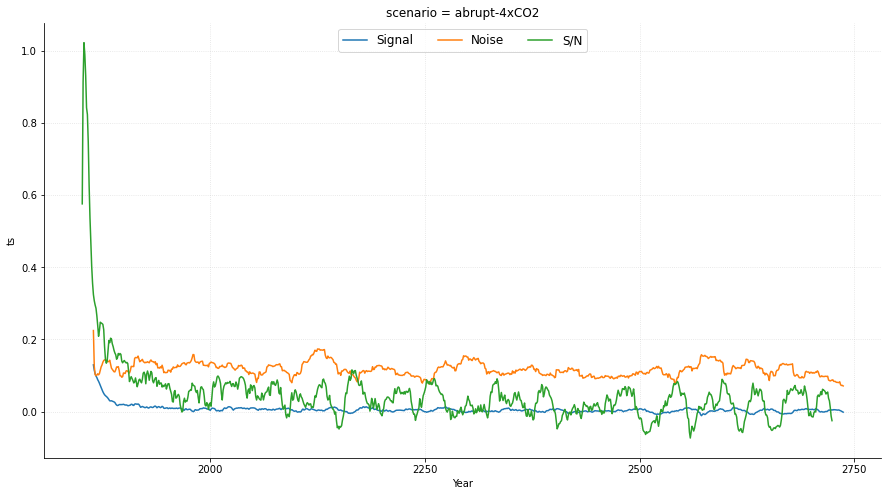

In [754]:
data = ipsl_smean_noise

fig, ax = plt.subplots(figsize = (15,8))


ipsl_abrupt_signal.plot(label = 'Signal', ax = ax)
ipsl_aburpt_noise_detrend.plot(label = 'Noise', ax = ax)
ipsl_abrupt_sn.plot(label = 'S/N', ax = ax)
# time = data.time.values
# for scenario in data.scenario.values:
#     ax.plot(time, data.sel(scenario = scenario), label = scenario)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Year')
ax.grid(alpha = 0.4, linestyle = ':')
ax.legend(loc = 'upper center', ncol = 3, fontsize = 12)

# Earliest Exceedance

In [705]:
def retrieve_earliest_exceedance(data, threshold, thresh_type = np.less):
    
    data_exceed = data.where(thresh_type(data,threshold))
    
    # The shape of the data.
    shape = data.values.shape
    # The axis time is stored in
    time_axis = ipsl_smean_sn.get_axis_num('time')
    # Creating an empty array that is similar to the data
    reverse_arg = np.zeros_like(data.values)

    # Creating a loop bacwards in time.
    for t in np.arange(shape[time_axis],0,-1):
        # We are loading in the reverse of the arguement * 100
        # reverse_arg[0] = len(time) * 100
        # reverse_arg[1] = (len(time) - 1) * 100
        # reverse_args[len(time)] = (len(time) - len(time)) * 100 = 0
        reverse_arg[...,shape[time_axis] - t] = t * 100
        
    # Early values will now be larger.   
    data_exceed_arg = data_exceed + reverse_arg
        
    data_first_instance = data_exceed_arg.idxmax(dim = 'time')
    
    return data_first_instance

In [706]:
data = ipsl_smean_sn
threshold  = 1
ipsl_first_instance = retrieve_earliest_exceedance(data, threshold, thresh_type = np.less)
ipsl_first_instance

<xarray.DataArray 'time' (scenario: 4)>
array([cftime.DatetimeGregorian(1850, 12, 30, 20, 20, 24, 0),
       cftime.DatetimeGregorian(1850, 12, 30, 20, 20, 24, 0),
       cftime.DatetimeGregorian(1850, 12, 30, 20, 20, 24, 0),
       cftime.DatetimeGregorian(1850, 12, 30, 20, 20, 24, 0)],
      dtype=object)
Coordinates:
  * scenario  (scenario) object '1pctCO2' 'abrupt-4xCO2' ... 'piControl'

In [707]:
ipsl_smean_sn.values.shape

(4, 1000)

In [708]:
np.zeros_like(ipsl_smean_sn.values).shape

(4, 1000)

In [709]:
ipsl_smean_sn.get_axis_num('time')

1

In [710]:
data = ipsl_smean_sn
threshold  = 1

data_exceed = data.where(data > threshold)

shape = data.values.shape

time_axis = ipsl_smean_sn.get_axis_num('time')
reverse_arg = np.zeros_like(data.values)

for t in np.arange(shape[time_axis],0,-1):
    reverse_arg[...,shape[time_axis] - t] = t * 100

In [711]:
data_exceed_arg = data_exceed + reverse_arg

In [712]:
data_exceed_arg

<xarray.DataArray 'ts' (scenario: 4, time: 1000)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time      (time) object 1837-12-30 20:20:24 ... 2836-12-30 20:20:24
  * scenario  (scenario) object '1pctCO2' 'abrupt-4xCO2' ... 'piControl'

In [755]:
# This is expected as this scenario doesn't actually exceed one.
all(np.isnan(data_exceed_arg.sel(scenario = 'historical')))

True

In [757]:
data_max_arg = data_exceed_arg.idxmax(dim = 'time')
data_max_arg

<xarray.DataArray 'time' (scenario: 4)>
array([nan, nan, nan, nan], dtype=object)
Coordinates:
  * scenario  (scenario) object '1pctCO2' 'abrupt-4xCO2' ... 'piControl'